### Importing necessary libraries

In [1]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import miceforest        as mf
import seaborn           as sns
import lightgbm          as lgb
import xgboost           as xgs
import mlflow
import shap
import sqlite3
import sys

sys.path.append(r'/home/saim/External_Functions')

from scipy                   import stats
from iminuit                 import Minuit
from imblearn.over_sampling  import ADASYN
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.ensemble        import IsolationForest
from ExternalFunctions       import Chi2Regression
from scipy.stats             import norm, lognorm, skewnorm, poisson
from ExternalFunctions       import nice_string_output, add_text_to_ax
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn                 import metrics
from sklearn.preprocessing   import StandardScaler
from sklearn.decomposition   import PCA
from sklearn.preprocessing   import OneHotEncoder
from catboost                import CatBoostClassifier
from catboost                import CatBoost

Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.scriptrun = azureml.core.script_run:ScriptRun._from_run_dto with exception (urllib3 1.26.8 (/home/saim/anaconda3/lib/python3.8/site-packages), Requirement.parse('urllib3<=1.26.7,>=1.23')).


In [2]:
# Plotting style stuff
plt.style.reload_library()
plt.rcParams['font.size'] = 18 
plt.style.use(['science', 'notebook', 'grid'])

blue = '#1f77b4'
golden = '#ff7f0e'
green = '#2ca02c'
red = '#d62728'
light_blue = '#17becf'

#### Reading data file

In [28]:
csv = pd.read_csv(r"/home/saim/Desktop/cs-training.csv")
col_names = list(csv.columns)

In [32]:
conn = sqlite3.connect('credit.db')
csv.to_sql('Credit', conn, index = False, if_exists = 'replace')
pd.read_sql('select * from Credit', conn)

The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [41]:
#for row in conn.execute('SELECT * FROM Credit'):
    #print(row)

In [36]:
query = 'select * from Credit' 

data = conn.execute(query).fetchall()
df_fromsql = pd.DataFrame(data)

df_fromsql.columns = col_names
df_fromsql.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


### Start Experiment

In [4]:
#mlflow.set_tracking_uri("http://localhost:5000/#/experiments/4")
#mlflow.get_tracking_uri()

#experiment_name = 'Credit Risk Modelling'    # Creating experiment
#mlflow.set_experiment(experiment_name)

#mlflow.start_run(run_name = 'imputation')

In [39]:
# Filters for values over a threshold and prints the distribution of y for that filtering

"""
def check_over_thresh(df, col_name, threshold):
    
    df['over_tresh'] = df[col_name] >= threshold
    df = df[df['over_tresh'] == True]
    print(df['SeriousDlqin2yrs'].value_counts())
    

def check_under_thresh(df, col_name, threshold):
    
    df['under_tresh'] = df[col_name] <= threshold
    df = df[df['under_tresh'] == True]
    print(df['SeriousDlqin2yrs'].value_counts())
"""

"\ndef check_over_thresh(df, col_name, threshold):\n    \n    df['over_tresh'] = df[col_name] >= threshold\n    df = df[df['over_tresh'] == True]\n    print(df['SeriousDlqin2yrs'].value_counts())\n    \n\ndef check_under_thresh(df, col_name, threshold):\n    \n    df['under_tresh'] = df[col_name] <= threshold\n    df = df[df['under_tresh'] == True]\n    print(df['SeriousDlqin2yrs'].value_counts())\n"

In [40]:
# Data imputation

def get_under_thresh(df, col_name, threshold):
    
    df['under_thresh'] = df[col_name] >= threshold
    df = df[df['under_thresh'] == False]
    df.drop(['under_thresh'], axis = 1, inplace = True)
    print('Max value of column:', df[col_name].max())
    
    return df


def drop_NAN(dataframe, column_name):
    df_dropped = dataframe.dropna(subset = [column_name])
    return df_dropped



df_fromsql.drop(['Unnamed: 0'], axis = 1, inplace = True)

# Monthly income is filled where NA and mode imputed where too salary unreasonably high
df_fromsql.loc[:, 'MonthlyIncome'].fillna((df.loc[:, 'MonthlyIncome'].mode()[0]), inplace=True)
df_fromsql.loc[df.MonthlyIncome > 90000, 'MonthlyIncome'] = df['MonthlyIncome'].median()

# NumberOfDependents is removed since NAN's only account for 2% of values
df1 = drop_NAN(df_fromsql, 'NumberOfDependents')      # df1 = first transformation


# ratios must be <= 1
df2 = get_under_thresh(df1, 'RevolvingUtilizationOfUnsecuredLines', 2)
df2 = get_under_thresh(df1, 'DebtRatio', 2)


df2.where(df2.loc[:, 'RevolvingUtilizationOfUnsecuredLines'] <= 1, 1, inplace = True)
df2.where(df2.loc[:, 'DebtRatio'] <= 1, 1, inplace = True)

Max value of column: 1.99867586
Max value of column: 1.998765432



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
#mon = list(df_tist['MonthlyIncome'])
#mon.sort(reverse = True)
#mon

#df1_test = df1_test.where(df1_test['DebtRatio'] < 1, 1, inplace = True). GOOD SCORE, but overfit

In [7]:
def feature_eng(df):
    
    # MonthlyIncomePerPerson: Monthly Income divided by the number of dependents
    df['MonthlyIncomePerPerson'] = df['MonthlyIncome'] / (df['NumberOfDependents']+1)
    df['MonthlyIncomePerPerson'].fillna(0, inplace=True)
    
    # isRetired: age is greater than 67 (Assumed Retirement Age)
    df['isRetired'] = np.where((df['age'] > 67), 1, 0)
    
    # Interquantile ranges of MonthlyIncome
    df['Q1_Monthly_Income'] = df['MonthlyIncome'] <= df['MonthlyIncome'].quantile(0.25)
    df['Q3_Monthly_Income'] = df['MonthlyIncome'] >= df['MonthlyIncome'].quantile(0.75)
    #df['Q2_Monthly_Income'] = df['MonthlyIncome'].between(3400, 8249)
    
 

    # Interquantile ranges of Revolving...
    df['Q1_Revolving'] = df['RevolvingUtilizationOfUnsecuredLines'] <= df['RevolvingUtilizationOfUnsecuredLines'].quantile(0.25)
    df['Q3_Revolving'] = df['RevolvingUtilizationOfUnsecuredLines'] >= df['RevolvingUtilizationOfUnsecuredLines'].quantile(0.75)

    df = pd.get_dummies(df, columns = ['Q1_Monthly_Income', 
                                       'Q3_Monthly_Income',
                                       'Q1_Revolving', 
                                       'Q3_Revolving'
                                      ], 
                        drop_first = True
                       )
    
    return df


#df2 = feature_eng(df1)
df3 = feature_eng(df2)
print(df2.shape)
df3.head()

(118309, 17)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyIncomePerPerson,isRetired,Q1_Monthly_Income_True,Q3_Monthly_Income_True,Q1_Revolving_True,Q3_Revolving_True
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,3040.0,0,0,1,0,1
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,1300.0,0,1,0,0,1
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,3042.0,0,1,0,0,1
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,3300.0,0,1,0,0,0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,63588.0,0,0,1,0,1


### Resampling and PCA

In [8]:
X = df3.iloc[:, 1:]
y = df3.iloc[:, 0:1]

Text(0, 0.5, 'Explained variance (%)')

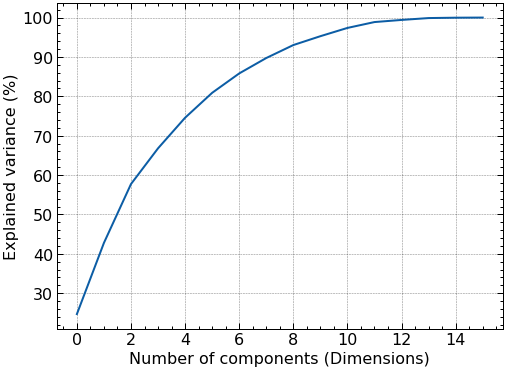

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA

pca = PCA(n_components=None)
pca.fit(X_scaled)


# Make the scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")

#pca = PCA(n_components=0.95)
#X_reduced = pca.fit_transform(X)

In [10]:
pca_final = PCA(n_components = 12)
X_pca = pca_final.fit_transform(X_scaled)

# Get the transformed dataset
X_pca = pd.DataFrame(X_pca)
X_pca
# plot heatmap again

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.006896,0.261551,4.587992,-1.532884,1.918969,0.637814,1.644289,0.797640,-0.564016,-1.723130,0.999930,0.753650
1,2.759643,-0.896147,-0.240039,1.494529,-0.475909,0.417557,0.202981,-0.306182,0.937108,-0.285160,0.934933,0.209894
2,2.463702,-0.501828,-0.688852,1.832135,-0.315206,-0.431131,0.027094,-0.380465,0.533898,-0.375044,0.877276,0.290427
3,1.118931,-0.556743,-1.366524,0.501246,-0.733985,-1.139303,-0.686321,-1.445800,0.192799,0.017182,0.476374,0.736701
4,-7.742683,4.296146,7.267918,10.151097,-0.110973,-4.414965,1.301950,-0.184851,-0.001399,7.844525,2.798301,-0.963339
...,...,...,...,...,...,...,...,...,...,...,...,...
118304,0.387172,-0.329795,-0.639274,0.178002,-0.009541,-0.182681,-1.342068,0.071342,-0.402448,-0.008519,-0.628333,-0.544200
118305,-0.023068,-0.328321,-2.639670,0.330956,1.616041,0.867743,0.749463,-1.710338,-0.852964,-0.182004,0.567705,0.303260
118306,0.716239,-0.531253,0.477729,-1.161543,-0.417751,0.362712,-0.211102,-0.011298,-1.280625,0.611924,-0.458714,-0.807103
118307,-0.521019,0.000458,-1.700858,0.281282,-1.545990,-1.576368,-0.142708,1.105737,-0.110271,0.269868,-0.359799,0.672087


In [11]:
# Train on resampled data
# Test on OG
X_train, X_test, y_train, y_test = train_test_split(X_pca, y,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    shuffle = True
                                                   )
print(X_train.shape)
print(X_test.shape)

(94647, 12)
(23662, 12)


In [12]:
random_undersampler = RandomUnderSampler(random_state = 42)
X_res, y_res = random_undersampler.fit_resample(X_train, y_train)

print(X_res.shape)
print(y_res.shape)

(21304, 12)
(21304, 1)


## Modelling

In [13]:
def evaluation(model, model_name):
    prediction = model.predict(X_test)
    probabilities = model.predict_proba(X_test)
    
    fpr, tpr, thresh = metrics.roc_curve(y_test, probabilities[:, 1])
    roc_auc = metrics.auc(fpr, tpr)
    
    print(model_name, 'AUC:', round(roc_auc, 3), '\n', 
          metrics.classification_report(y_test, prediction))
    
    return prediction, probabilities, roc_auc, tpr, fpr

In [31]:
xgb_model = xgs.XGBClassifier(use_label_encoder = False,
                              learning_rate = 0.7, 
                              max_depth = 10, 
                              n_estimators = 100, 
                              reg_alpha = 0.5, 
                              reg_lambda = 0.2,
                              colsample_bytree = 1, 
                              colsample_bylevel = 0.2, 
                              colsample_bynode = 1, 
                              scale_pos_weight = 21
                             )

# parameter optimization
grid_params = {'learning_rate' : list(np.arange(0.0, 1.0, 0.1)),
               'max_depth': [i for i in range(15)],
               'n_estimators' : [i for i in range(50, 1000, 50)],
               'reg_alpha' : list(np.arange(0.0, 1.0, 0.1)), 
               'reg_lambda' : list(np.arange(0.0, 1.0, 0.1)),
               'colsample_bytree' : list(np.arange(0.0, 1.0, 0.1)),
               'colsample_bylevel' : list(np.arange(0.0, 1.0, 0.1)),
               'colsample_bynode' : list(np.arange(0.0, 1.0, 0.1)),
               'scale_pos_weight' : [i for i in range(30)]
              }

xgb_optimized = RandomizedSearchCV(xgb_model, 
                               param_distributions = grid_params, 
                               random_state = 42, 
                               cv = 5
                              )

xgb_optimized.fit(X_res, y_res.values.ravel(), eval_metric = 'rmse')

KeyboardInterrupt: 

In [23]:
print(xgb_optimized.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=0.2, colsample_bytree=0.9,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=14,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=950, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=2,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


In [14]:
xgb_final = xgs.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=0.2, colsample_bytree=0.9,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=14,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=950, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=2,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


xgb_final.fit(X_res, y_res.values.ravel(), eval_metric = 'rmse')

# eval metrics
xgb_pred, xgb_proba, xgb_roc_auc, xgb_tpr, xgb_fpr = evaluation(xgb_final, 'XGBoost')

XGBoost AUC: 0.895 
               precision    recall  f1-score   support

           0       0.97      0.85      0.91     21026
           1       0.40      0.78      0.53      2636

    accuracy                           0.84     23662
   macro avg       0.68      0.82      0.72     23662
weighted avg       0.91      0.84      0.86     23662



## Light GBM

In [82]:
lgbm_model = lgb.LGBMClassifier(boosting_type = 'gbdt', 
                                   objective = 'binary', 
                                   learning_rate = 0.1, 
                                   random_state = 42
                                  )

# parameter optimization
lgbm_grid_params = {
                    'learning_rate' : list(np.arange(0.0, 1.0, 0.1)),
                    'max_depth': [i for i in range(15)],
                    'num_leaves': [i for i in range(100)],
                    'n_estimators' : [i for i in range(50, 1000, 50)],
                    'subsample_for_bin': [i for i in range (1000000, 10000000, 1000000)],
                    'reg_alpha' : list(np.arange(0.0, 1.0, 0.1)), 
                    'reg_lambda' : list(np.arange(0.0, 1.0, 0.1)),
                    'colsample_bytree' : list(np.arange(0.0, 1.0, 0.1)),
                    }

lgbm_optimized = RandomizedSearchCV(lgbm_model, 
                               param_distributions = lgbm_grid_params, 
                               random_state = 42, 
                               cv = 5
                              )

lgbm_optimized.fit(X_res, y_res.values.ravel(), eval_metric = 'rmse')

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 331 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 331 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 331 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 331 .

[LightGBM] [Fatal] Check failed: (learning_rate) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 331 .

[LightGBM] [Fatal] Check failed: (feature_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 372 .

[LightGBM] [Fatal] Check failed: (feature_fraction) > (0.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 372 .

[LightGBM] [Fatal] Check failed: (feature_fraction) > (0.0) at /__w/1/s/python-package/compile/src

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(objective='binary',
                                            random_state=42),
                   param_distributions={'colsample_bytree': [0.0, 0.1, 0.2,
                                                             0.30000000000000004,
                                                             0.4, 0.5,
                                                             0.6000000000000001,
                                                             0.7000000000000001,
                                                             0.8, 0.9],
                                        'learning_rate': [0.0, 0.1, 0.2,
                                                          0.30000000000000004,
                                                          0.4, 0.5,
                                                          0.6000000000000001,
                                                          0.7000000000000001,
          

In [83]:
print(lgbm_optimized.best_estimator_)

LGBMClassifier(colsample_bytree=0.2, learning_rate=0.6000000000000001,
               max_depth=1, n_estimators=850, num_leaves=49, objective='binary',
               random_state=42, reg_alpha=0.9, reg_lambda=0.4,
               subsample_for_bin=5000000)


In [15]:
lgbm_final = lgb.LGBMClassifier(colsample_bytree=0.2, learning_rate=0.6000000000000001,
               max_depth=1, n_estimators=850, num_leaves=49, objective='binary',
               random_state=42, reg_alpha=0.9, reg_lambda=0.4,
               subsample_for_bin=5000000)


lgbm_final.fit(X_res, y_res.values.ravel(), eval_metric = 'rmse')

# eval metrics
lgbm_pred, lgbm_proba, lgbm_roc_auc, lgbm_tpr, lgbm_fpr = evaluation(lgbm_final, 'Light GBM')

Light GBM AUC: 0.91 
               precision    recall  f1-score   support

           0       0.97      0.90      0.94     21026
           1       0.50      0.77      0.61      2636

    accuracy                           0.89     23662
   macro avg       0.73      0.84      0.77     23662
weighted avg       0.92      0.89      0.90     23662



## CatBoost

In [16]:
cat_model = CatBoostClassifier(iterations = 2, depth = 2)

# parameter optimization
cat_grid_params = {
                    'learning_rate' : list(np.arange(0.0, 1.0, 0.1)),
                    'depth': [i for i in range(17)],
                    'bagging_temperature': [i for i in range(1000)],
                    'l2_leaf_reg' : list(np.arange(0.0, 1.0, 0.1)),
                    }

cat_optimized = RandomizedSearchCV(cat_model, 
                               param_distributions = cat_grid_params, 
                               random_state = 42, 
                               cv = 5
                              )

cat_optimized.fit(X_res, y_res.values.ravel())

0:	learn: 0.4500445	total: 137ms	remaining: 137ms
1:	learn: 0.3896675	total: 230ms	remaining: 0us
0:	learn: 0.4514680	total: 97.8ms	remaining: 97.8ms
1:	learn: 0.3917337	total: 203ms	remaining: 0us
0:	learn: 0.4506801	total: 105ms	remaining: 105ms
1:	learn: 0.3920476	total: 204ms	remaining: 0us
0:	learn: 0.4510959	total: 113ms	remaining: 113ms
1:	learn: 0.3899183	total: 222ms	remaining: 0us
0:	learn: 0.4517798	total: 153ms	remaining: 153ms
1:	learn: 0.3975590	total: 252ms	remaining: 0us
0:	learn: 0.5092579	total: 188ms	remaining: 188ms
1:	learn: 0.4323820	total: 369ms	remaining: 0us
0:	learn: 0.5102393	total: 184ms	remaining: 184ms
1:	learn: 0.4344096	total: 350ms	remaining: 0us
0:	learn: 0.5096999	total: 184ms	remaining: 184ms
1:	learn: 0.4343245	total: 366ms	remaining: 0us
0:	learn: 0.5099832	total: 245ms	remaining: 245ms
1:	learn: 0.4324234	total: 474ms	remaining: 0us
0:	learn: 0.5101817	total: 198ms	remaining: 198ms
1:	learn: 0.4308718	total: 385ms	remaining: 0us
0:	learn: 0.607819


5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/saim/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/saim/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 4768, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/home/saim/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 2073, in _fit
    train_params = self._prepare_train_params(
  File "/home/saim/anaconda3/lib/py

0:	learn: 0.4547392	total: 106ms	remaining: 106ms
1:	learn: 0.3972367	total: 199ms	remaining: 0us


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f13cd535e80>,
                   param_distributions={'bagging_temperature': [0, 1, 2, 3, 4,
                                                                5, 6, 7, 8, 9,
                                                                10, 11, 12, 13,
                                                                14, 15, 16, 17,
                                                                18, 19, 20, 21,
                                                                22, 23, 24, 25,
                                                                26, 27, 28, 29, ...],
                                        'depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                  10, 11, 12, 13, 14, 15, 16],
                                        'l2_leaf_reg': [0.0, 0.1, 0.2,
                                                        0.30000000000000004,
              

In [17]:
cat_pred, cat_proba, cat_roc_auc, cat_tpr, cat_fpr = evaluation(cat_optimized, 'CatBoost')

CatBoost AUC: 0.891 
               precision    recall  f1-score   support

           0       0.97      0.88      0.92     21026
           1       0.44      0.76      0.56      2636

    accuracy                           0.86     23662
   macro avg       0.70      0.82      0.74     23662
weighted avg       0.91      0.86      0.88     23662



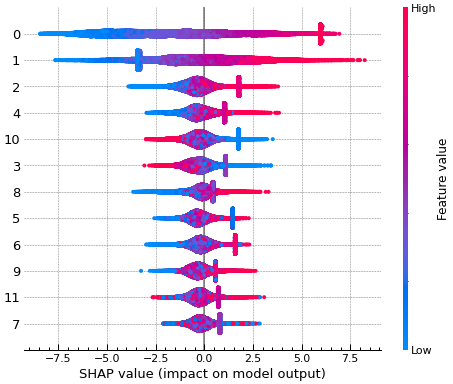

In [21]:
# Shap
tree_explainer = shap.TreeExplainer(xgb_final)
#shap_object = tree_explainer(X_train)
shap_values = tree_explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, axis_color = '#000000', show = False)

plt.savefig("shap.png")
mlflow.log_artifact("shap.png")
#plt.savefig("/home/saim/Desktop/shap.png")

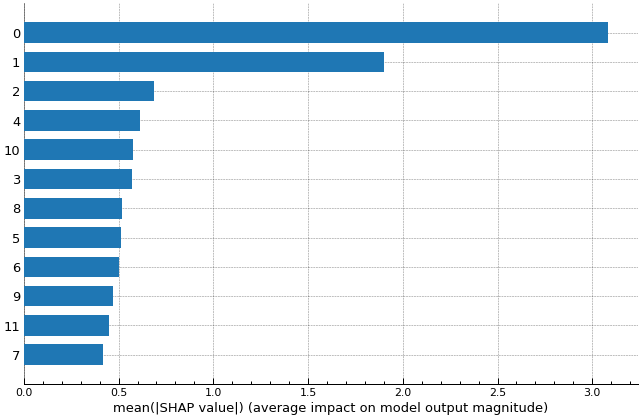

In [22]:
shap.summary_plot(shap_values, 
                  feature_names = X_train.columns, 
                  plot_type = 'bar', 
                  axis_color = '#000000',
                  color = blue, 
                  #alpha = 0.7,
                  show = False,
                  plot_size = (11,7) 
                 )

plt.savefig("shap_bar.png")
#mlflow.log_artifact("shap_bar.png")
#plt.savefig("/home/saim/Desktop/shap_bar.png")

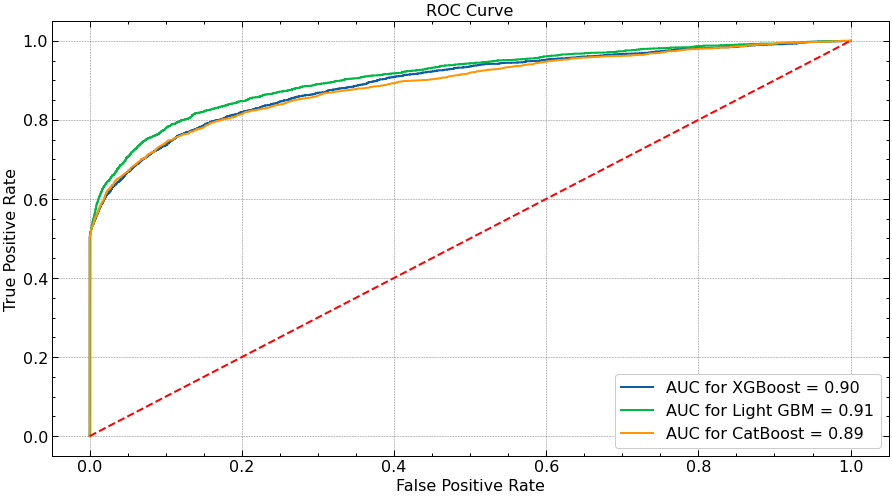

In [23]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(xgb_fpr, xgb_tpr, label = 'AUC for XGBoost = %0.2f' % xgb_roc_auc)
ax.plot(lgbm_fpr, lgbm_tpr, label = 'AUC for Light GBM = %0.2f' % lgbm_roc_auc)
ax.plot(cat_fpr, cat_tpr, label = 'AUC for CatBoost = %0.2f' % cat_roc_auc)

ax.plot([0, 1], [0, 1],'r--')

ax.set(xlabel = "False Positive Rate", ylabel = "True Positive Rate")
ax.legend(loc = 'lower right')
    
plt.savefig("ROC.png")
mlflow.log_artifact("ROC.png")

plt.title('ROC Curve')
plt.show()

In [19]:
lgbDF = pd.DataFrame({'Probability of Default': lgbm_proba[:,1]})
lgbDF.head(20)

,Probability of Default
0,0.818399
1,0.130962
2,0.889285
3,0.481104
4,0.109488
5,0.998321
6,0.054415
7,0.508857
8,0.317596
9,0.069150


In [ ]:
# Log model
mlflow.xgboost.log_model(xgb_model = xgb_final, 
                         artifact_path = '',
                         #registered_model_name = 'Baseline'
                        )

# Log parameters
mlflow.log_params({'use_label_encoder' : 'False'})
mlflow.log_params({'learning_rate' : '0.7'})
mlflow.log_params({'max_depth' : '10'})
mlflow.log_params({'n_estimators' : '100'})
mlflow.log_params({'reg_alpha' : '0.5'})
mlflow.log_params({'reg_lambda' : '0.2'})
mlflow.log_params({'booster' : 'gbtree'})
mlflow.log_params({'colsample_bytree' : '1'})
mlflow.log_params({'colsample_bylevel' : '0.2'})
mlflow.log_params({'colsample_bynode' : '1'})
mlflow.log_params({'scale_pos_weight' : '21'})


# Log conda environment
conda_env = mlflow.xgboost.get_default_conda_env()

# Log confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_xgb)
t_n, f_p, f_n, t_p = cm.ravel()

mlflow.log_metric("True Negative", t_n)
mlflow.log_metric("False Positive", f_p)
mlflow.log_metric("False Negative", f_n)
mlflow.log_metric("True Positive", t_p)


# Log classification report
xgb_report = pd.DataFrame(metrics.classification_report(y_test, y_pred_xgb, output_dict = True)).transpose()
xgb_report.to_csv('classification_report.csv', index = True)
mlflow.log_artifact('classification_report.csv')

# Log roc_auc
fpr, tpr, thresh = metrics.roc_curve(y_test, probability_xgb[:,1])
roc_auc = metrics.auc(fpr, tpr)
mlflow.log_metric('AUC', roc_auc)

# Log f1
f1 = metrics.f1_score(y_test, y_pred_xgb)
mlflow.log_metric('f1', f1)

# Log precision
precision = metrics.precision_score(y_test, y_pred_xgb)
mlflow.log_metric('precision', precision)

# Log recall 
recall = metrics.recall_score(y_test, y_pred_xgb)
mlflow.log_metric('recall', recall)

mlflow.end_run()